# Correlation-Based Random Forest Classification

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [26]:
# load data
correlation_training_data = pd.DataFrame.from_csv('checkpoint_files/top_4_correlation_training_data.csv')
correlation_training_data.head()

,pert_id,target,label,A375,A549,MCF7,PC3
0,BRD-K21680192,TOP2A,1.0,0.489878,0.141628,-0.183952,-0.123435
1,BRD-K81418486,HDAC1,1.0,0.348987,-0.088103,0.135304,0.276418
2,BRD-K81418486,HDAC2,1.0,0.275635,0.235417,-0.001411,0.135818
3,BRD-K81418486,HDAC3,1.0,0.333418,0.168260,0.213528,0.287947
4,BRD-K81418486,HDAC6,1.0,0.411440,0.308649,0.195380,0.310055


In [27]:
# balance True and False samples
pos_samples = correlation_training_data[correlation_training_data.label == 1]
neg_samples = correlation_training_data[correlation_training_data.label == -1].sample(n=pos_samples.shape[0])
balanced_training_data = np.vstack([pos_samples,neg_samples])

In [28]:
# shuffle the data
perm = np.random.RandomState(1).permutation(balanced_training_data.shape[0])
shuffled_training_data = balanced_training_data[perm]

In [29]:
# separate features and labels
X = shuffled_training_data[:,3:7].astype(float)
y = shuffled_training_data[:,2].astype(float)

In [30]:
# scale the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

In [59]:
# random forest classification
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=10)
clf.fit(X_std, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [60]:
print('Accuracy: {:.2f}'.format(clf.score(X_std, y)))

Accuracy: 0.93


In [61]:
results = pd.DataFrame(shuffled_training_data, columns=correlation_training_data.columns)
results['prediction'] = clf.predict(X_std).astype(int)

In [62]:
false_interactions = results[results.label==-1]
false_accuracy = (false_interactions[false_interactions.prediction==-1].shape[0] /
                  false_interactions.shape[0])

true_interactions = results[results.label==1]
true_accuracy = (true_interactions[true_interactions.prediction==1].shape[0] /
                  true_interactions.shape[0])


print('Accuracy on False interactions: {:.2f}'.format(false_accuracy))
print('Accuracy on True interactions: {:.2f}'.format(true_accuracy))

Accuracy on False interactions: 0.95
Accuracy on True interactions: 0.91


Not so good. But better than if we hadn't balanced the data beforehand (if we don't balance the data we get 100% accuracy on the negative samples and 0% accuracy on the positive samples).
<br><br>

It seems we need to construct additional features. But first let's try to evaluate the importance of the features that we do have.

Feature ranking:
1. feature 0 (0.282029)
2. feature 1 (0.262015)
3. feature 3 (0.228192)
4. feature 2 (0.227764)


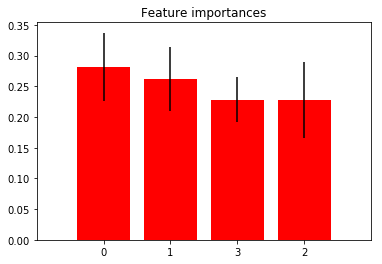

In [40]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0) # standard deviation of importances
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_std.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_std.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_std.shape[1]), indices)
plt.xlim([-1, X_std.shape[1]])
plt.show()

___
# Logistic Regression

For fun, let's see how we can do with simple logistic regression.

In [18]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_std, y)
print('Accuracy: {:.2f}'.format(lr.score(X_std, y)))

Accuracy: 0.54


In [19]:
results = pd.DataFrame(shuffled_training_data, columns=correlation_training_data.columns)
results['prediction'] = lr.predict(X_std).astype(int)

In [20]:
false_interactions = results[results.label==-1]
false_accuracy = (false_interactions[false_interactions.prediction==-1].shape[0] /
                  false_interactions.shape[0])

true_interactions = results[results.label==1]
true_accuracy = (true_interactions[true_interactions.prediction==1].shape[0] /
                  true_interactions.shape[0])


print('Accuracy on False interactions: {:.2f}'.format(false_accuracy))
print('Accuracy on True interactions: {:.2f}'.format(true_accuracy))

Accuracy on False interactions: 0.56
Accuracy on True interactions: 0.52
